# Pós Tech Challenge FIAP - Fase 1

Este notebook apresenta o desenvolvimento de um modelo preditivo de regressão para estimar os custos médicos individuais cobrados pelo seguro de saúde, conforme desafio proposto na Fase 1 do Pós Tech da FIAP.

**Integrantes do grupo:**
- Carlos Adriano
- Daniel Kiluange
- Leonardo Nogueira

O passo a passo inclui:
- Carregamento e exploração dos dados
- Pré-processamento e tratamento de valores ausentes
- Conversão de variáveis categóricas
- Visualização exploratória
- Separação dos dados em treino e teste
- Treinamento do modelo de regressão linear
- Avaliação e visualização dos resultados

O objetivo é construir um modelo capaz de prever os encargos médicos a partir das características dos clientes, utilizando técnicas de aprendizado supervisionado.

In [22]:
import pandas as pd
import numpy as np
from scipy.stats import alpha

##### Carregando o dataset

In [23]:
raw_dataset = pd.read_csv('dataset.csv')

##### Verificando se o dataset possui valores nulos e exibindo informações gerais do mesmo

In [24]:
print(raw_dataset.head())
raw_dataset.info()
print(raw_dataset.isnull().sum())

   idade     genero    imc fumante    regiao  encargos
0     56  masculino  24.54     não   sudeste   9816.22
1     69  masculino  18.24     sim  nordeste  21870.06
2     46   feminino  26.23     não     norte   6969.30
3     32  masculino  19.08     não   sudeste   6603.50
4     60  masculino  25.64     não   sudeste   8780.76
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   idade     100000 non-null  int64  
 1   genero    100000 non-null  object 
 2   imc       100000 non-null  float64
 3   fumante   100000 non-null  object 
 4   regiao    100000 non-null  object 
 5   encargos  100000 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB
idade       0
genero      0
imc         0
fumante     0
regiao      0
encargos    0
dtype: int64


##### Podemos perceber que as colunas SEXO, FUMANTE e REGIAO podem ser convertidas em valores numéricos, pois são categóricas

In [25]:
num_dataset = raw_dataset.copy()

In [26]:
num_dataset['regiao'] = (
    num_dataset['regiao'].map({'norte': 1, 'nordeste': 2, 'centro-oeste': 3, 'sudeste': 4, 'sul': 5}))
num_dataset['genero'] = num_dataset['genero'].map({'masculino': 0, 'feminino': 1})
num_dataset['fumante'] = num_dataset['fumante'].map({'não': 0, 'sim': 1})
print(num_dataset.head())
num_dataset.info()

   idade  genero    imc  fumante  regiao  encargos
0     56       0  24.54        0       4   9816.22
1     69       0  18.24        1       2  21870.06
2     46       1  26.23        0       1   6969.30
3     32       0  19.08        0       4   6603.50
4     60       0  25.64        0       4   8780.76
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   idade     100000 non-null  int64  
 1   genero    100000 non-null  int64  
 2   imc       100000 non-null  float64
 3   fumante   100000 non-null  int64  
 4   regiao    100000 non-null  int64  
 5   encargos  100000 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 4.6 MB


##### Com os dados padronizados, podemos exibi-los em gráficos para facilitar algumas análises

array([[<Axes: title={'center': 'idade'}>,
        <Axes: title={'center': 'genero'}>],
       [<Axes: title={'center': 'imc'}>,
        <Axes: title={'center': 'fumante'}>],
       [<Axes: title={'center': 'regiao'}>,
        <Axes: title={'center': 'encargos'}>]], dtype=object)

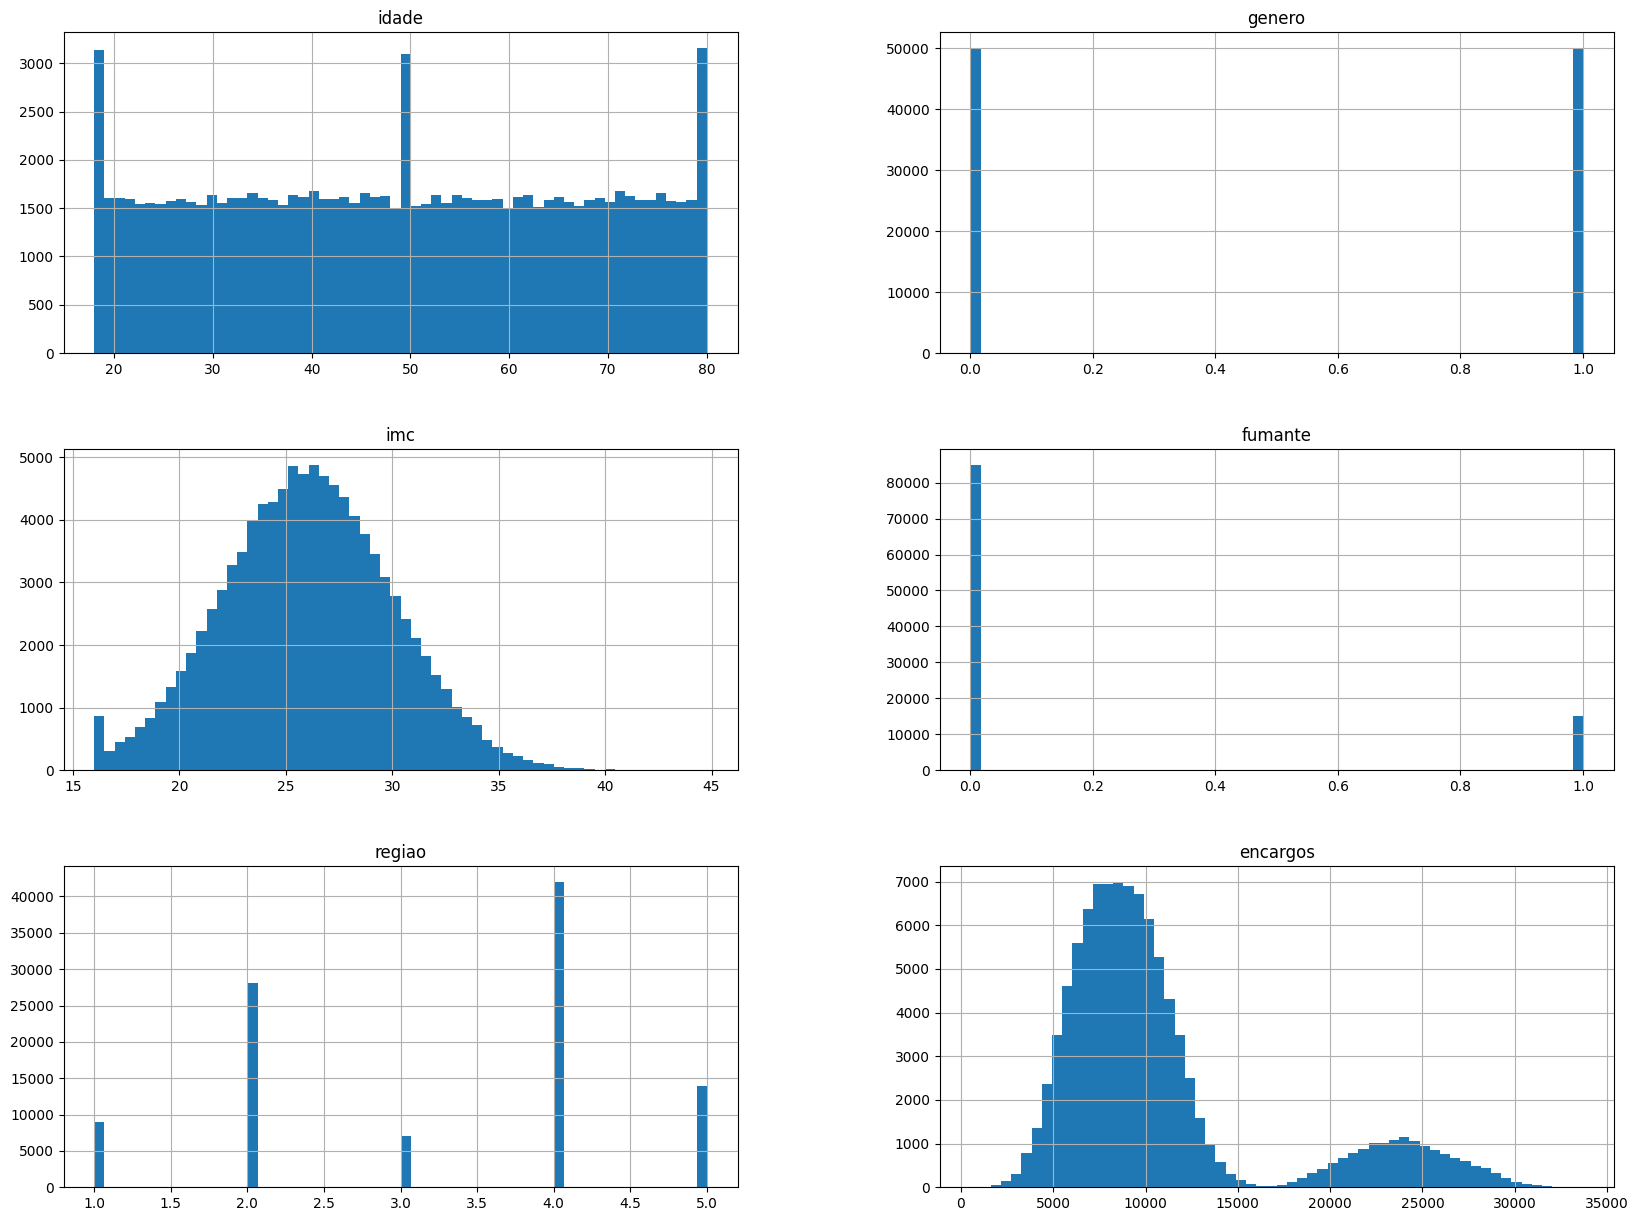

In [27]:
num_dataset.hist(bins=60, figsize=(20, 15))
#import matplotlib.pyplot as plt
#plt.hist(num_dataset, bins=60, color=['skyblue','skyblue','skyblue','skyblue','skyblue','skyblue'], edgecolor=['black','black','black','black','black','black'])

##### Separando características entre categóricas e numéricas para a configuração do pré-processador

In [28]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

# Create preprocessing steps
numeric_features = ['idade', 'imc']
categorical_features = ['genero', 'fumante', 'regiao']


In [29]:
from sklearn.compose import ColumnTransformer

X = num_dataset[['idade', 'imc', 'genero', 'fumante', 'regiao']]
y = num_dataset['encargos']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)


##### Avaliando modelos treinados

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


def evaluate_model(y_true, y_pred):
    metrics = {
        'R²': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    return metrics


models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name} model...")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    pipeline.fit(X_train, y_train)

    train_predictions = pipeline.predict(X_train)
    test_predictions = pipeline.predict(X_test)

    train_metrics = evaluate_model(y_train, train_predictions)
    test_metrics = evaluate_model(y_test, test_predictions)

    print(f"Métricas no conjunto de treino:")
    for metric, value in train_metrics.items():
        print(f"  {metric}: {value:.4f}")

    print(f"Métricas no conjunto de teste:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")

    results[name] = {
        'pipeline': pipeline,
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics
    }
# create a pipeline object

Training Linear Regression model...
Métricas no conjunto de treino:
  R²: 0.9655
  MAE: 886.7729
  RMSE: 1114.6858
  MAPE: 10.0756
Métricas no conjunto de teste:
  R²: 0.9663
  MAE: 883.5625
  RMSE: 1113.1044
  MAPE: 10.0481
Training Ridge Regression model...
Métricas no conjunto de treino:
  R²: 0.9655
  MAE: 885.2500
  RMSE: 1114.2514
  MAPE: 10.0793
Métricas no conjunto de teste:
  R²: 0.9661
  MAE: 887.2406
  RMSE: 1114.1921
  MAPE: 10.0526
Training Lasso Regression model...
Métricas no conjunto de treino:
  R²: 0.9656
  MAE: 885.2651
  RMSE: 1114.5511
  MAPE: 10.0564
Métricas no conjunto de teste:
  R²: 0.9660
  MAE: 887.0036
  RMSE: 1113.4963
  MAPE: 10.1105
Training Random Forest model...
Métricas no conjunto de treino:
  R²: 0.9939
  MAE: 361.2624
  RMSE: 467.1015
  MAPE: 4.2336
Métricas no conjunto de teste:
  R²: 0.9628
  MAE: 928.8765
  RMSE: 1165.8736
  MAPE: 10.7713
Training Gradient Boosting model...
Métricas no conjunto de treino:
  R²: 0.9697
  MAE: 833.3077
  RMSE: 104

##### Comparando os resultados entre os modelos e destacando modelo com melhor performance

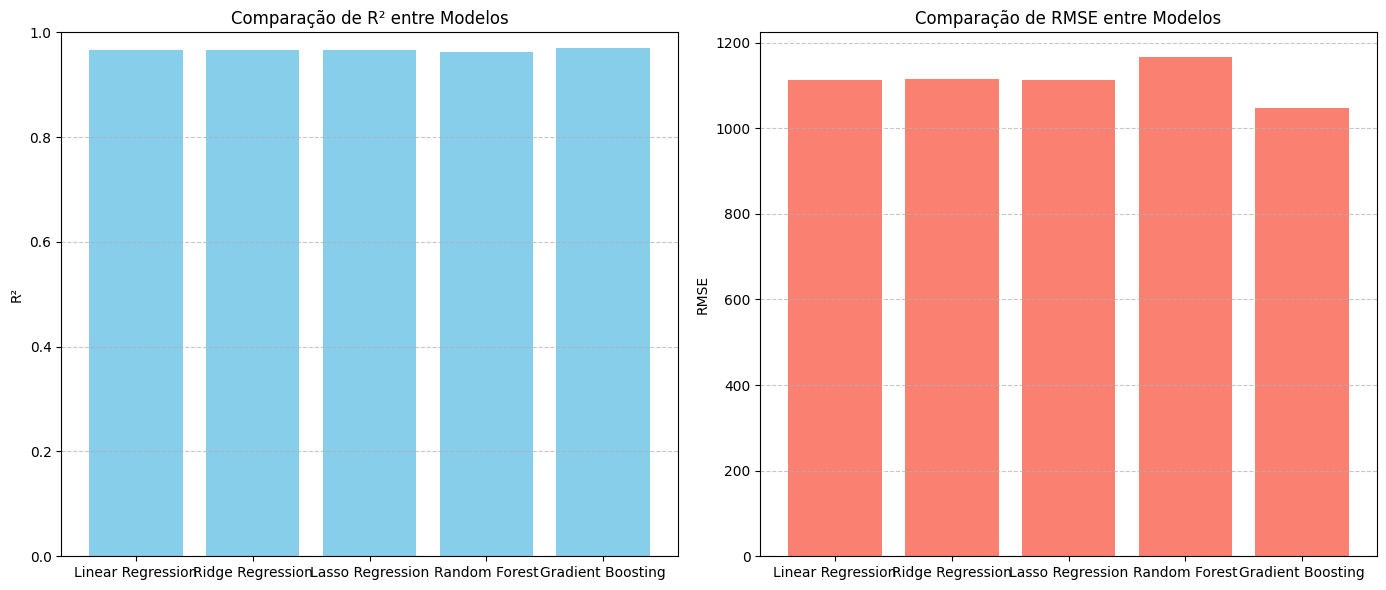


Melhor modelo: Gradient Boosting
R² no conjunto de teste: 0.9699
RMSE no conjunto de teste: 1046.4007


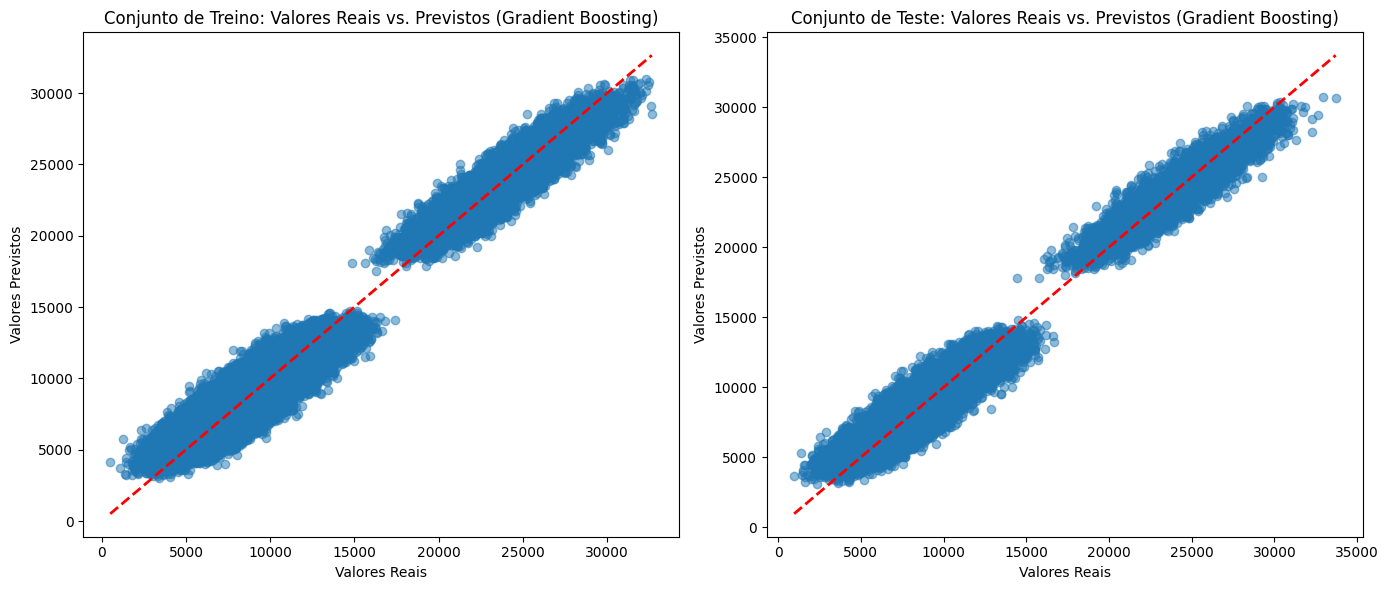

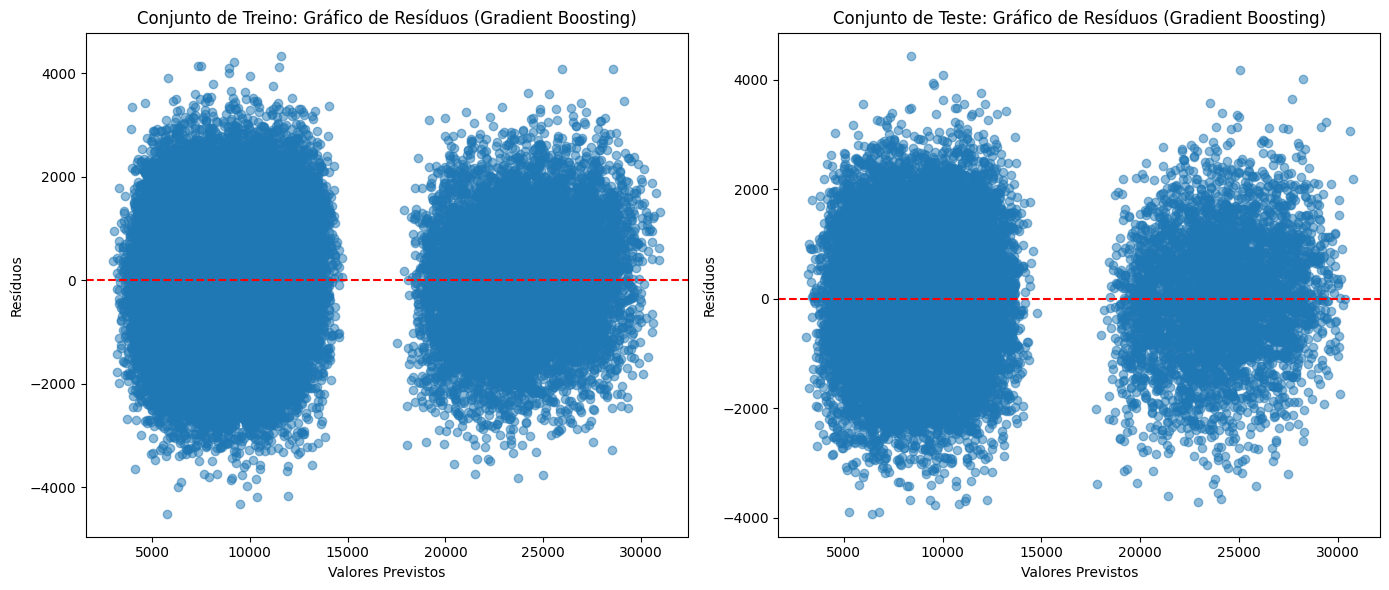

In [31]:
from matplotlib import pyplot as plt


# Visualização dos resultados
def visualize_model_results(results):
    # Comparação de métricas entre modelos
    model_names = list(results.keys())
    r2_scores = [results[name]['test_metrics']['R²'] for name in model_names]
    rmse_scores = [results[name]['test_metrics']['RMSE'] for name in model_names]

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].bar(model_names, r2_scores, color='skyblue')
    ax[0].set_title('Comparação de R² entre Modelos')
    ax[0].set_ylabel('R²')
    ax[0].set_ylim(0, 1)
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)

    ax[1].bar(model_names, rmse_scores, color='salmon')
    ax[1].set_title('Comparação de RMSE entre Modelos')
    ax[1].set_ylabel('RMSE')
    ax[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Selecionando o melhor modelo para visualizações detalhadas
    best_model_name = model_names[np.argmax(r2_scores)]
    best_model_results = results[best_model_name]

    print(f"\nMelhor modelo: {best_model_name}")
    print(f"R² no conjunto de teste: {best_model_results['test_metrics']['R²']:.4f}")
    print(f"RMSE no conjunto de teste: {best_model_results['test_metrics']['RMSE']:.4f}")

    # Visualizando previsões vs. valores reais
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Conjunto de treino
    ax[0].scatter(y_train, best_model_results['train_predictions'], alpha=0.5)
    ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    ax[0].set_xlabel('Valores Reais')
    ax[0].set_ylabel('Valores Previstos')
    ax[0].set_title(f'Conjunto de Treino: Valores Reais vs. Previstos ({best_model_name})')

    # Conjunto de teste
    ax[1].scatter(y_test, best_model_results['test_predictions'], alpha=0.5)
    ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax[1].set_xlabel('Valores Reais')
    ax[1].set_ylabel('Valores Previstos')
    ax[1].set_title(f'Conjunto de Teste: Valores Reais vs. Previstos ({best_model_name})')

    plt.tight_layout()
    plt.show()

    # Visualizando resíduos
    residuals_train = y_train - best_model_results['train_predictions']
    residuals_test = y_test - best_model_results['test_predictions']

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Resíduos no conjunto de treino
    ax[0].scatter(best_model_results['train_predictions'], residuals_train, alpha=0.5)
    ax[0].axhline(y=0, color='r', linestyle='--')
    ax[0].set_xlabel('Valores Previstos')
    ax[0].set_ylabel('Resíduos')
    ax[0].set_title(f'Conjunto de Treino: Gráfico de Resíduos ({best_model_name})')

    # Resíduos no conjunto de teste
    ax[1].scatter(best_model_results['test_predictions'], residuals_test, alpha=0.5)
    ax[1].axhline(y=0, color='r', linestyle='--')
    ax[1].set_xlabel('Valores Previstos')
    ax[1].set_ylabel('Resíduos')
    ax[1].set_title(f'Conjunto de Teste: Gráfico de Resíduos ({best_model_name})')

    plt.tight_layout()
    plt.show()

    return best_model_name, best_model_results['pipeline']


# Visualizando resultados dos modelos
best_model_name, best_pipeline = visualize_model_results(results)


##### Avaliando as características com maior peso em relação aos encargos

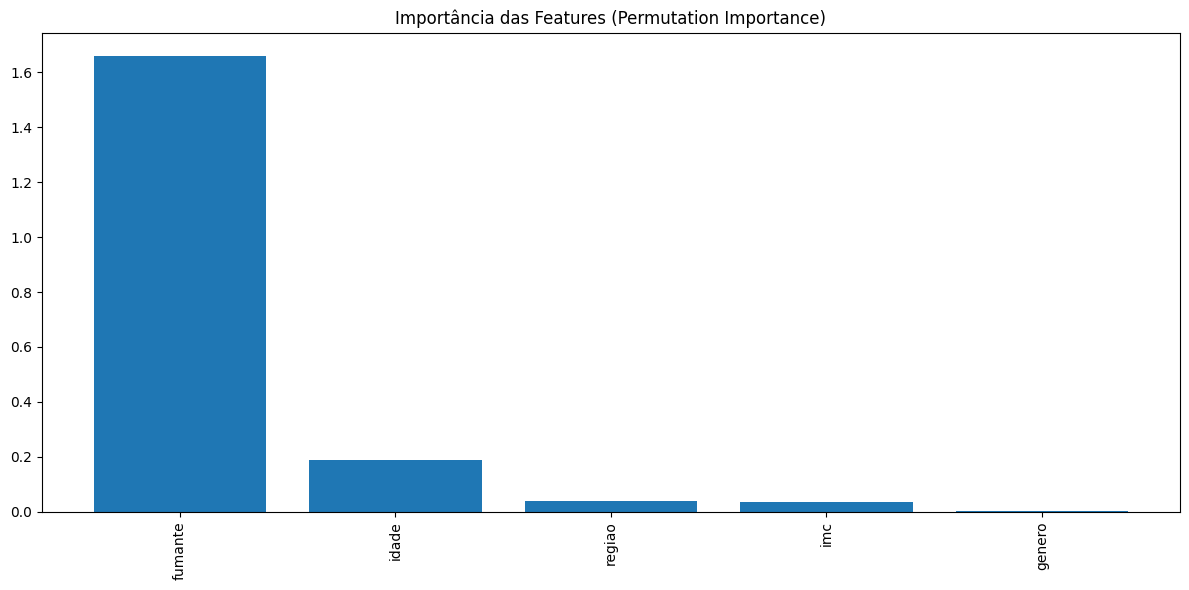

In [32]:
from sklearn.inspection import permutation_importance

# Análise de importância de features
# Obtendo nomes das features após one-hot encoding
categorical_features = ['genero', 'fumante', 'regiao']
numeric_features = ['idade', 'imc']
# Calculando importância das features usando permutation importance
result = permutation_importance(
    pipeline, X_test, y_test, n_repeats=10, random_state=42
)

# Obtendo importâncias e seus índices ordenados
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

# Obtendo nomes das features transformadas
preprocessor = pipeline.named_steps['preprocessor']
transformed_X_train = preprocessor.transform(X_train)

# Obtendo nomes das features após transformação
transformed_feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if name == 'num':
        transformed_feature_names.extend(numeric_features)
    elif name == 'cat':
        for feature in categorical_features:
            categories = X_train[feature].unique()
            # Excluindo a primeira categoria (drop='first')
            for category in categories[1:]:
                transformed_feature_names.append(f"{feature}_{category}")

# Visualizando importância das features
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [X_train.columns.tolist()[i] for i in indices], rotation=90)
plt.title('Importância das Features (Permutation Importance)')
plt.tight_layout()
plt.show()

##### Executando nova previsão com dados categorizados para visualizar a influência da característica com maior peso do passo anterior

In [33]:
# Exemplo de novos dados para previsão
new_data_non_smoker = pd.DataFrame([
    [56, 0, 24.54, 0, 4],  # Homem, 56 anos, IMC 24.54, não fumante, sudeste
    [34, 1, 22.10, 0, 3],  # Mulher, 34 anos, IMC 22.10, não fumante, centro-oeste
    [45, 0, 28.30, 0, 5],  # Homem, 45 anos, IMC 28.30, não fumante, sul
], columns=['idade', 'genero', 'imc', 'fumante', 'regiao'])

print("Novos dados para previsão de não fumantes:")
print(new_data_non_smoker)
predictions_non_smoker = best_pipeline.predict(new_data_non_smoker)

print("\nPrevisões de encargos médicos de não fumantes:")
for i, pred in enumerate(predictions_non_smoker):
    print(f"Pessoa {i + 1}: R$ {pred:.2f}")

Novos dados para previsão de não fumantes:
   idade  genero    imc  fumante  regiao
0     56       0  24.54        0       4
1     34       1  22.10        0       3
2     45       0  28.30        0       5

Previsões de encargos médicos de não fumantes:
Pessoa 1: R$ 9292.39
Pessoa 2: R$ 6253.14
Pessoa 3: R$ 8435.64


In [34]:
new_data_smoker = pd.DataFrame([
    [56, 0, 24.54, 1, 4],  # Homem, 56 anos, IMC 24.54, fumante, sudeste
    [34, 1, 22.10, 1, 3],  # Mulher, 34 anos, IMC 22.10, fumante, centro-oeste
    [45, 0, 28.30, 1, 5],  # Homem, 45 anos, IMC 28.30, fumante, sul
], columns=['idade', 'genero', 'imc', 'fumante', 'regiao'])

print("Novos dados para previsão de fumantes:")
print(new_data_smoker)
predictions_smoker = best_pipeline.predict(new_data_smoker)

for i, pred in enumerate(predictions_smoker):
    print(f"Pessoa {i + 1}: R$ {pred:.2f}")

Novos dados para previsão de fumantes:
   idade  genero    imc  fumante  regiao
0     56       0  24.54        1       4
1     34       1  22.10        1       3
2     45       0  28.30        1       5
Pessoa 1: R$ 25479.71
Pessoa 2: R$ 21308.43
Pessoa 3: R$ 24071.79


##### Visualizando um comparativo entre fumantes e nao fumantes na base testada temos a comprovação de que o aumento do custo está diretamente relacionado a característica de fumante


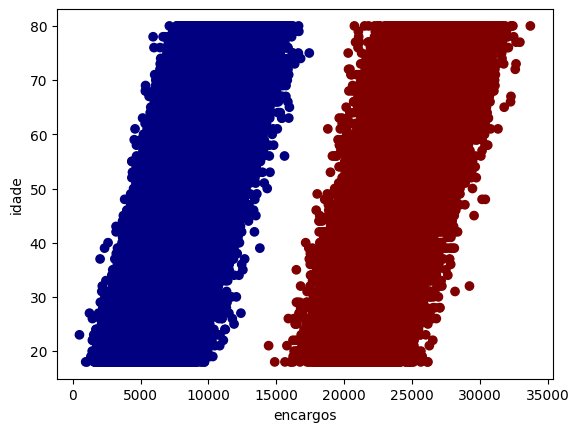

In [35]:
plt.scatter(num_dataset['encargos'], num_dataset['idade'], c=num_dataset['fumante'], cmap=plt.get_cmap("jet"))
plt.xlabel('encargos')
plt.ylabel('idade')
plt.show()
